In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from types import SimpleNamespace
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
%matplotlib inline
warnings.filterwarnings("ignore")
%matplotlib inline
sns.set()
sns.set_style("whitegrid")
sns.set_palette("GnBu_d")

# Prediction
In this notebook we make two different Predictions. For the first Prediction we use trip_duration as the dependent variable and for the second we use amount of bikes as dependent variable.

In [2]:
brm_hourly = pd.read_csv("../generated/brm_hourly.csv")
frb_hourly = pd.read_csv("../generated/frb_hourly.csv")

In [3]:
def timedelta_to_hours(timedelta_array):
    return timedelta_array.map(lambda x: x / pd.Timedelta("1 hour"))

def add_weekday(frame):
    frame["day"] = pd.to_datetime(frame["day"])
    frame["weekday"] = frame["day"].map(lambda x: x.weekday())
    return frame

def regression(frame,frame_model):
    y = frame["trip_duration"]
    X = frame[["temperature","precipitation"]]
    frame_model.fit(X, y)
    predict = frame_model.predict(X)
    return predict

def plot_regression(X,y, predict):
    plt.figure(figsize = (8,6))
    plt.scatter(X, y, marker="x")
    plt.xlabel("temperature in °C")
    plt.ylabel("trip duration in h")
    plt.plot(X, predict, c='C2')
    plt.legend(['Squared loss fit','Observed hours'])


def triple_split(X, y, train_size, validate_size):
    if (train_size+validate_size) <= 1:
        x_train, x_tmp, y_train, y_tmp = train_test_split(X, y, test_size=(1-train_size))
        x_validate, x_test, y_validate, y_test = train_test_split(x_tmp, y_tmp, test_size=(1-validate_size/(1-train_size)))
        return x_train, x_validate, x_test, y_train, y_validate, y_test

In [4]:
def linear_regression(input):
    model = LinearRegression()
    model.fit(input[0], input[2])
    predict = model.predict(input[1])
    y_pred = model.predict(input[0])
    mse = mean_squared_error(input[3], predict)
    r2 = r2_score(input[3], predict)

    return SimpleNamespace(**{"mse": mse, "r2": r2, "x_train": input[0], "y_train": input[2], "y_pred": y_pred})


def polynomial_regression(input, degree):
    model = LinearRegression()
    poly_features = PolynomialFeatures(degree=degree)
    x_poly = poly_features.fit_transform(input[0])
    x_poly_test = poly_features.fit_transform(input[1])
    model.fit(x_poly, input[2])

    predict = model.predict(x_poly_test)
    y_pred = model.predict(x_poly)
    mse = mean_squared_error(input[3], predict)
    r2 = r2_score(input[3], predict)

    return SimpleNamespace(**{"mse": mse, "r2": r2, "x_train": input[0], "y_train": input[2], "y_pred": y_pred})


def ridge_regression(input, degree, alpha):
    poly_features = PolynomialFeatures(degree=degree)
    x_poly = poly_features.fit_transform(input[0])
    x_poly_test = poly_features.fit_transform(input[1])

    model = Ridge(alpha, normalize=True)
    model.fit(x_poly, input[2])
    predict = model.predict(x_poly_test)
    y_pred = model.predict(x_poly)

    mse = mean_squared_error(input[3], predict)
    r2 = r2_score(input[3], predict)

    return SimpleNamespace(**{"mse": mse, "r2": r2, "x_train": input[0], "y_train": input[2], "y_pred": y_pred})


def lasso_regression(input, degree, alpha):
    poly_features = PolynomialFeatures(degree=degree)
    x_poly = poly_features.fit_transform(input[0])
    x_poly_test = poly_features.fit_transform(input[1])

    model = Lasso(alpha, normalize=True)
    model.fit(x_poly, input[2])
    predict = model.predict(x_poly_test)
    y_pred = model.predict(x_poly)

    mse = mean_squared_error(input[3], predict)
    r2 = r2_score(input[3], predict)

    return SimpleNamespace(**{"mse": mse, "r2": r2, "x_train": input[0], "y_train": input[2], "y_pred": y_pred})

In [5]:
def test_regression_alpha(start, end, step_size, regression, split, degree=4):
    mse_array = []
    r2_array = []
    alpha_array = []
    
    best_alpha = 0

    alpha = start
    while alpha < end:
        obj = regression(split, degree, alpha)
        alpha_array.append(alpha)
        if len(r2_array) == 0 or obj.r2 > max(r2_array):
            best_alpha = alpha
        r2_array.append(obj.r2)
        mse_array.append(obj.mse)

        alpha += step_size
    
    plt.subplot(1,2,1)
    plt.plot(alpha_array, r2_array)
    plt.title("R^2")
    plt.xlabel("alpha")
    
    plt.subplot(1,2,2)
    plt.plot(alpha_array, mse_array)
    plt.title("MSE")
    plt.xlabel("alpha")
    
    plt.show()
    
    print("Best alpha: ", best_alpha)
    print("Max R^2: ", max(r2_array))
    print("Min mse: ", min(mse_array))
    

def test_amount_features(frame, predictor_name):
    features=[]
    features.append(np.array(frame["temperature"]).reshape(-1,1))
    features.append(frame[["temperature", "hour"]])
    features.append(frame[["temperature", "hour", "weekday"]])
    features.append(frame[["temperature", "hour", "weekday", "precipitation"]])

    predictor = frame[predictor_name]

    mse_array = []
    r2_array = []

    x_values = range(0, len(features))

    for i in x_values:
        split = train_test_split(features[i], predictor, random_state=0, test_size=0.2)
        out = polynomial_regression(split, 3)
        mse_array.append(out.mse)
        r2_array.append(out.r2)

    plt.subplot(1,2,1)
    plt.plot(x_values, r2_array)
    plt.title("R^2")
    plt.xlabel("Number of features")

    plt.subplot(1,2,2)
    plt.plot(x_values, mse_array)
    plt.title("MSE")
    plt.xlabel("Number of features")

    plt.show()

    print("Max R^2: ", max(r2_array))
    print("Min mse: ", min(mse_array))


def test_degree(start, end, step_size, split):
    mse_array = []
    r2_array = []
    degree_array = []

    degree = start
    while degree < end:
        obj = polynomial_regression(split, degree)
        degree_array.append(degree)
        r2_array.append(obj.r2)
        mse_array.append(obj.mse)
        degree += step_size

    plt.subplot(1,2,1)
    plt.plot(degree_array, r2_array)
    plt.title("R^2")
    plt.xlabel("degree")

    plt.subplot(1,2,2)
    plt.plot(degree_array, mse_array)
    plt.title("MSE")
    plt.xlabel("degree")
    plt.show()

    print("Max R^2: ", max(r2_array))
    print("Min mse: ", min(mse_array))

In [6]:
def visualize_features(frame, var_name):
    trip_duration = frame[var_name]
    f1 = frame["temperature"]
    f2 = frame["precipitation"]
    f3 = frame["hour"]
    f4 = frame["weekday"]

    fig = plt.figure(figsize = (12,4))
    
    ax = fig.add_subplot(2,2,1)
    ax.scatter(f1,trip_duration, marker='x')
    ax.set_xlabel("High Temperature (°C)")
    ax.set_ylabel(var_name)

    bx =  fig.add_subplot(2,2,2)
    bx.scatter(f2,trip_duration, marker='x')
    bx.set_xlabel("Precipitation (mm)")
    bx.set_ylabel(var_name)

    cx =  fig.add_subplot(2,2,3)
    cx.scatter(f3,trip_duration, marker='x')
    cx.set_xlabel("Hour of day")
    cx.set_ylabel(var_name)

    dx =  fig.add_subplot(2,2,4)
    dx.scatter(f4,trip_duration, marker='x')
    dx.set_xlabel("Weekday")
    dx.set_ylabel(var_name)

    plt.show()

In [7]:
frb_hourly["trip_duration"] = timedelta_to_hours(frb_hourly["trip_duration"])
brm_hourly["trip_duration"] = timedelta_to_hours(brm_hourly["trip_duration"])

# 1. Regression with trip duration as dependent variable

### Visualization of the four features for the regression
(Temperature, Precipitation, Hour, Weekday)
- Freiburg: 

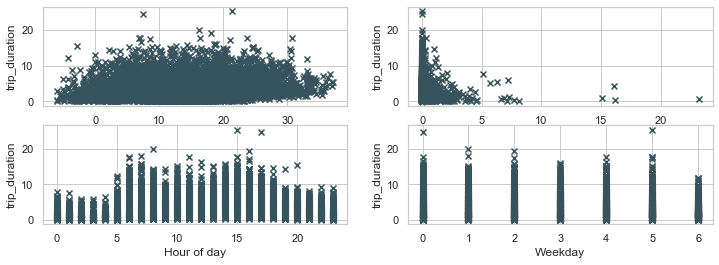

In [8]:
visualize_features(frb_hourly, "trip_duration")

- Bremen

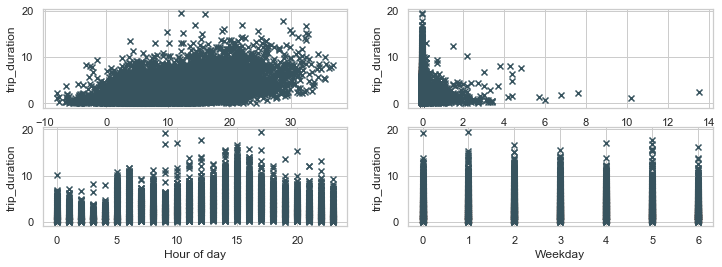

In [9]:
visualize_features(brm_hourly, "trip_duration")

Now we split the frb and brm data into a train- and a test-set

In [10]:
frb_features = frb_hourly[["temperature","hour", "weekday", "precipitation"]]
frb_predictor = frb_hourly["trip_duration"]

frb_split = train_test_split(frb_features, frb_predictor, test_size=0.2, random_state=0)

brm_features = brm_hourly[["temperature","hour", "weekday", "precipitation"]]
brm_predictor = brm_hourly["trip_duration"]

brm_split = train_test_split(brm_features, brm_predictor, test_size=0.2, random_state=0)

### Linear Regression
- Freiburg

In [11]:
out = linear_regression(frb_split)
print("R^2:" ,out.r2)

R^2: 0.07583061660802193


- Bremen

In [12]:
out = linear_regression(brm_split)
print("R^2: ",out.r2)

R^2:  0.24959126597479342


As we can see the $R^2$ of Freiburg is much lower than in Bremen since
we miss 5 months of data from January to May 2019.

### Polynomial regression

In order to determinate the best degree for a polynomial regression we plotted the $MSE$ and the $R^2$ value for multiple degrees
- Freiburg

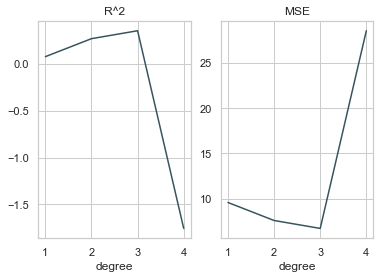

Max R^2:  0.3522706355246754
Min mse:  6.713130041624283


In [13]:
test_degree(1, 5, 1, frb_split)

- Bremen

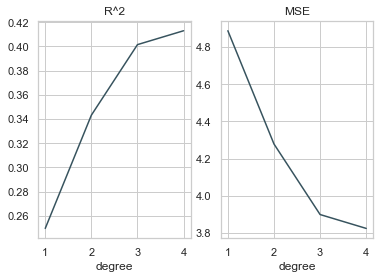

Max R^2:  0.41299533878743366
Min mse:  3.823734573797149


In [14]:
test_degree(1, 5, 1, brm_split)

To ensure that multiple features actually increase the *r2* value we plotted a graph with degree=3
- Freiburg


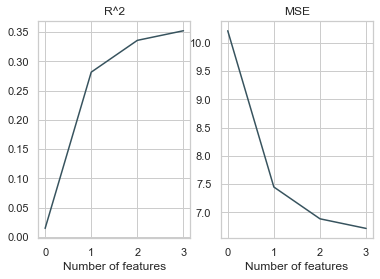

Max R^2:  0.3522706355246754
Min mse:  6.713130041624283


In [15]:
test_amount_features(frb_hourly, "trip_duration")

- Bremen

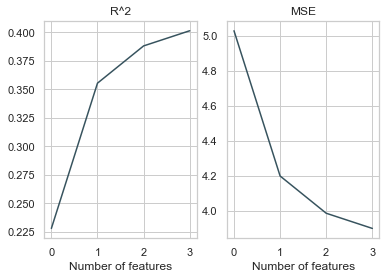

Max R^2:  0.40152267459114677
Min mse:  3.8984672388671138


In [16]:
test_amount_features(brm_hourly, "trip_duration")


### Ridge regression
In the following the optimal alpha will be determined for the ridge and the lasso regression
- Freiburg

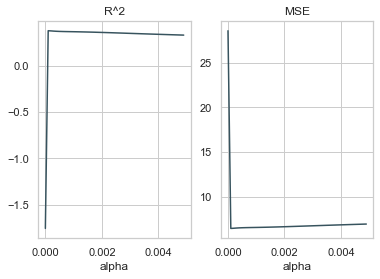

Best alpha:  0.0001
Max R^2:  0.3748826057176532
Min mse:  6.478777386444367


In [17]:
test_regression_alpha(0, 0.005, 0.0001, ridge_regression, frb_split)

- Bremen

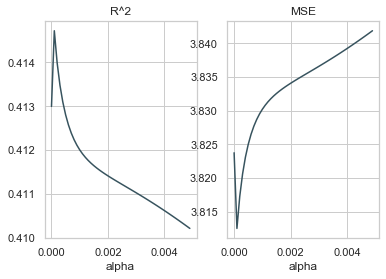

Best alpha:  0.0001
Max R^2:  0.4147218510009064
Min mse:  3.81248811379613


In [18]:
test_regression_alpha(0, 0.005, 0.0001, ridge_regression, brm_split)


### Lasso regression
- Freiburg

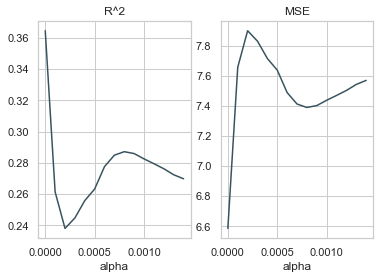

Best alpha:  0
Max R^2:  0.3646079902507319
Min mse:  6.585264499025712


In [19]:
test_regression_alpha(0, 0.0015, 0.0001, lasso_regression, frb_split)

- Bremen

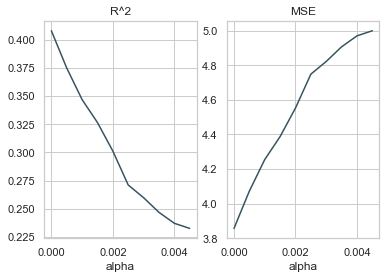

Best alpha:  0
Max R^2:  0.4079001430155649
Min mse:  3.856924559363728


In [20]:
test_regression_alpha(0, 0.005, 0.0005, lasso_regression, brm_split)

# 2. Regression with trip duration as dependent variable

### Visualization of the four features for the regression
(Temperature, Precipitation, Hour, Weekday)
- Freiburg:

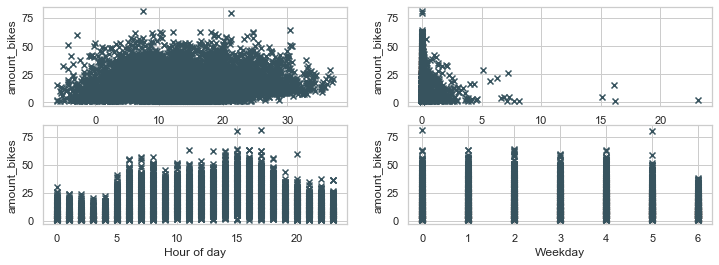

In [21]:
visualize_features(frb_hourly, "amount_bikes")

- Bremen

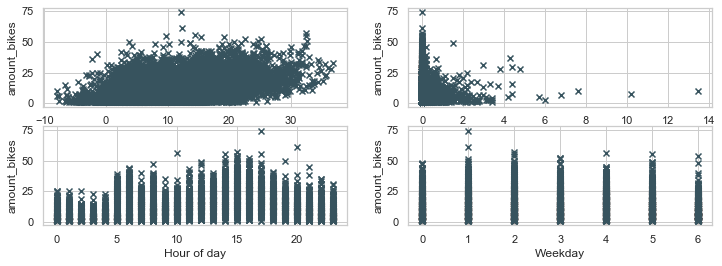

In [22]:
visualize_features(brm_hourly, "amount_bikes")

Now we split the frb and brm data into a train- and a test-set

In [23]:
frb_features = frb_hourly[["temperature","hour", "weekday", "precipitation"]]
frb_predictor = frb_hourly["amount_bikes"]

frb_split = train_test_split(frb_features, frb_predictor, test_size=0.2, random_state=0)

brm_features = brm_hourly[["temperature","hour", "weekday", "precipitation"]]
brm_predictor = brm_hourly["amount_bikes"]

brm_split = train_test_split(brm_features, brm_predictor, test_size=0.2, random_state=0)

### Linear Regression
- Freiburg

In [24]:
out = linear_regression(frb_split)
print("R^2:" ,out.r2)

R^2: 0.08618688139865804


- Bremen

In [25]:
out = linear_regression(brm_split)
print("R^2: ",out.r2)

R^2:  0.22120132277111249


As we can see the $R^2$ of Freiburg is much lower than in Bremen since
we miss 5 months of data from January to May 2019.

### Polynomial regression

In order to determinate the best degree for a polynomial regression we plotted the $MSE$ and the $R^2$ value for multiple degrees
- Freiburg

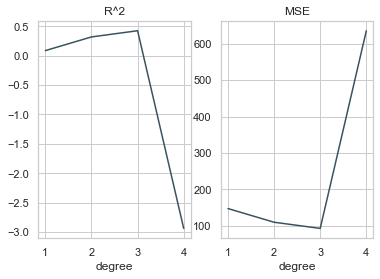

Max R^2:  0.423903632259811
Min mse:  92.95512614125477


In [26]:
test_degree(1, 5, 1, frb_split)

- Bremen

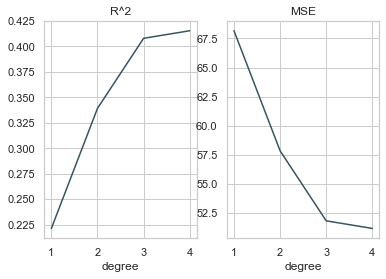

Max R^2:  0.4154478127797374
Min mse:  51.161545732775956


In [27]:
test_degree(1, 5, 1, brm_split)

To ensure that multiple features actually increase the *r2* value we plotted a graph with degree=3
- Freiburg


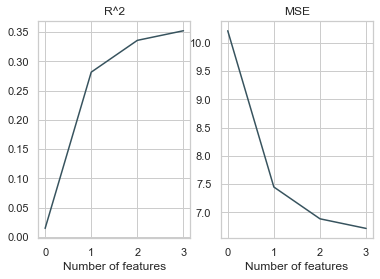

Max R^2:  0.3522706355246754
Min mse:  6.713130041624283


In [28]:
test_amount_features(frb_hourly, "trip_duration")

- Bremen

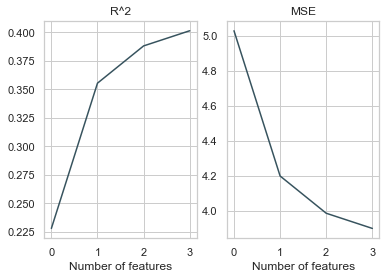

Max R^2:  0.40152267459114677
Min mse:  3.8984672388671138


In [29]:
test_amount_features(brm_hourly, "trip_duration")


### Ridge regression
In the following the optimal alpha will be determined for the ridge and the lasso regression
- Freiburg

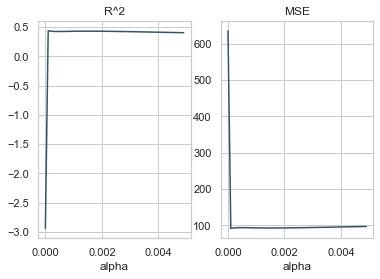

Best alpha:  0.0001
Max R^2:  0.4347427797460517
Min mse:  91.20619249357455


In [30]:
test_regression_alpha(0, 0.005, 0.0001, ridge_regression, frb_split)

- Bremen

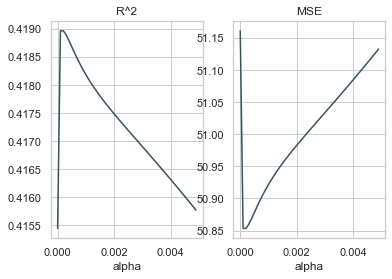

Best alpha:  0.0002
Max R^2:  0.41896984069863163
Min mse:  50.85328858074733


In [31]:
test_regression_alpha(0, 0.005, 0.0001, ridge_regression, brm_split)


### Lasso regression
- Freiburg

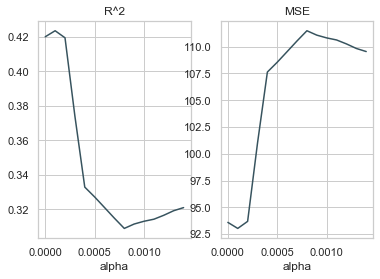

Best alpha:  0.0001
Max R^2:  0.42341855253049265
Min mse:  93.03339542041066


In [32]:
test_regression_alpha(0, 0.0015, 0.0001, lasso_regression, frb_split)

- Bremen

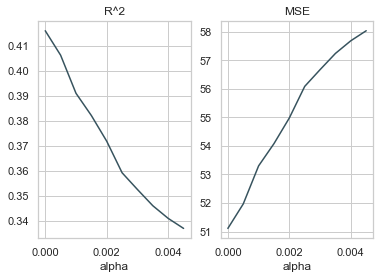

Best alpha:  0
Max R^2:  0.4160120170572591
Min mse:  51.11216508964755


In [33]:
test_regression_alpha(0, 0.005, 0.0005, lasso_regression, brm_split)